## Traveling Salesman Problem and GA

Following from: https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

In [1]:
%matplotlib notebook
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    def __lt__(self, other):
        if self.x < other.x:
            return True
        elif self.x == other.x and self.y < other.y:
            return True
        else:
            return False

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [10]:
#Partially Mapped Crossover method of recombination/child generation
def PMX(parent1, parent2):
    child = [None] * len(parent1)
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    tmpIndex = 0
    i = None #Holds the city in parent2 that needs placed
    j = None #Holds the city in parent1 that is in the place i was in parent 2
    k = None #Used to find a position to place i in the child
    
    for index in range(startGene, endGene):
        child[index] = parent1[index]
        
        if parent2[index] not in parent1[startGene:endGene]:
            i = parent2[index]
            j = parent1[index]
            tmpIndex = parent2.index(j)
            
            while startGene <= tmpIndex and tmpIndex < endGene:
                k = parent1[tmpIndex]
                tmpIndex = parent2.index(k)

            child[tmpIndex] = i
        #print(f"Child  : {child}\n")
            
    for index in range(0, len(parent2)):
        if child[index] == None:
            child[index] = parent2[index]
            
    #print(f"Parent1: {parent1}\n")
    #print(f"Parent2: {parent2}\n")
    #print(f"Child  : {child}\n\n\n")
                
    return child

In [11]:
def CalcIndex(lst, cIndex):
    
    lIndex = cIndex - 1
    rIndex = cIndex + 1
        
    if lIndex < 0:
        lIndex = len(lst) - 1
            
    if rIndex >= len(lst):
        rIndex = 0
        
    dictry = {"left":lIndex, "right":rIndex}
        
    return dictry

In [87]:
def GenerateEdgeTable(parent1, parent2):
    edges = {x: [] for x in parent1}
    
    cIndex = None
    sideIn = None
    
    for index in range(0, len(parent1)):
        sideIn = CalcIndex(parent1, index)
        
        #print(f"cIndex: {index}, lIndex: {sideIn["left"]}, rIndex: {sideIn["right"]}\n")
        
        edges[parent1[index]].append(parent1[sideIn["left"]])
        edges[parent1[index]].append(parent1[sideIn["right"]])
        
        cIndex = parent2.index(parent1[index])
        sideIn = CalcIndex(parent2, cIndex)
        
        edges[parent1[index]].append(parent2[sideIn["left"]])
        edges[parent1[index]].append(parent2[sideIn["right"]])
        
    return edges

In [110]:
def FindShortestListKey(edges, child):
    shortest = []
    size = None
    item = None
    
    for key in edges:
        if key not in child:
            if size == None:
                size = len(edges[key])
                shortest.append(key)

            elif len(edges[key]) < size:
                size = len(edges[key])
                shortest = [key]

            elif len(edges[key]) == size:
                shortest.append(key)

    if len(shortest) > 1:
        item = shortest[random.randint(0, len(shortest) - 1)]
                    
    else:
        item = shortest[0]
    
    return item

In [111]:
#Edge Crossover method of recombination/child generation
def EX(parent1, parent2):
    child = []
    
    #A dictionary with each city as a key that connects to a list of its edges
    edges = None
    
    #Used to create child
    entry = None
    currElement = None
    count = None
    i = 0
    unused = []
    
    #print(f"edges is:\n{edges}")
    
    #1) Construct Edge Table
    edges = GenerateEdgeTable(parent1, parent2)
        
    #print(f"edges is:\n{edges}")
    
    #2) Pick a initial element @ random & put in offspring
    entry = random.choice(list(edges))
    child.append(entry)
    
    
    #3) Set the variable current_element = entry
    currElement = entry
    
    #print(f"currElement: {currElement}")
    
    while len(child) < len(parent1):
    
        #4) Remove all references to current_element from table
        for key in edges:
            try:
                #NOTE: Should look for a cleaner/better solution
                while True:
                    edges[key].remove(currElement)
                    
            except ValueError:
                pass

        #print(f"Removed currElem.  edges is:\n{edges}")
        
        if len(edges[currElement]) != 0:
            #print("edges[currElement] is not an empty list.")

            #5) Examine list for current_element
            count = Counter(edges[currElement]).most_common()

            #print(f"count is: {count}")
            #If there is a common edge, pick that to be the next element
            if count[0][1] == 2:
                #print("There is a common edge")
                i = 0

                while i < len(count) and count[i][1] == 2:
                    i += 1
                
                entry = count[random.randint(0, i - 1)][0]
                
                while entry in child:
                    entry = count[random.randint(0, i - 1)][0]
                    
                currElement = entry

            #Otherwise, pick the entry in the list which itself has the shortest list
            else:
                #print("There is NOT a common edge")
                currElement = FindShortestListKey(edges, child)

                #NOTE: Ties are split at random

        #6) In the case of reaching an empty list, a new element is chosen at random
        else:
            #print("edges[currElement] is an empty list.")
            unused = [item for item in parent1 if item not in child]
            #print(f"unused is: {unused}")
            
            currElement = unused[random.randint(0, len(unused) - 1)]
        
        #Reset Variables
        i = 0
        unused = []
        
        #print(f"child is: {child}")
        #print(f"New currElement: {currElement}\n\n")
        child.append(currElement)
        
    #print(f"child is: {child}\n\n\n")
    
    return child

In [121]:
#Order Crossover method of recombination/child generation
def OX(parent1, parent2):
    child = [None] * len(parent1)
    
    #Choose 2 crossover points at random
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    rng = endGene - startGene #MIGHT NOT NEED
    cpIndex = endGene
    
    #Copy over segment from parent1 into child
    for index in range(startGene, endGene):
        child[index] = parent1[index]
        
    #Start from the end of the crossover point in parent 2 and copy over any elements not currently in child
    for i in range(0, len(parent1)):
        if cpIndex >= len(parent1):
            cpIndex = 0
            
        
    
    
    return child

In [83]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        #child = breed(pool[i], pool[len(matingpool)-i-1])
        #child = PMX(pool[i], pool[len(matingpool) - i - 1])
        child = EX(pool[i], pool[len(matingpool) - i - 1])
        children.append(child)
    return children

In [14]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [15]:
def InversionMutation(individual, mutationRate):
    if(random.random() < mutationRate):
        #print("Mutating!")
        
        #Randomly selects the section of the route to reverse
        index1 = random.randint(0, len(individual) - 1)
        index2 = random.randint(0, len(individual) - 1)

        smallIndex = min(index1, index2)
        bigIndex = max(index1, index2)
        index = 0
        
        #print(f"smallIndex: {smallIndex} bigIndex: {bigIndex}")
        #print(f"Individual before: {individual}")
        
        swapped = smallIndex + index
        swapWith = bigIndex - index
        
        while swapped < swapWith:
            #print(f"range is: {bigIndex - smallIndex}, Index is: {index}")
            #print(f"swapped is: {swapped}, swapWith is: {swapWith}")
            
            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
            
            index += 1
            swapped = smallIndex + index
            swapWith = bigIndex - index
            
        #print(f"Individual after : {individual}\n\n\n")
        
    return individual

In [16]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        #mutatedInd = mutate(population[ind], mutationRate)
        mutatedInd = InversionMutation(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [17]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
#    for i in popRanked:
#        print(i)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
#    for i in matingpool:
#        print(i)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [18]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [19]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [114]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 1959.966086926681
Final distance: 861.9916464964185


[(1,131),
 (33,124),
 (25,94),
 (49,83),
 (48,60),
 (78,73),
 (100,83),
 (70,51),
 (97,36),
 (107,25),
 (108,15),
 (175,5),
 (165,64),
 (126,86),
 (172,124),
 (155,146),
 (175,158),
 (194,165),
 (171,183),
 (121,169),
 (75,146),
 (59,165),
 (65,174),
 (64,181),
 (21,196)]

In [21]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

<IPython.core.display.Javascript object>


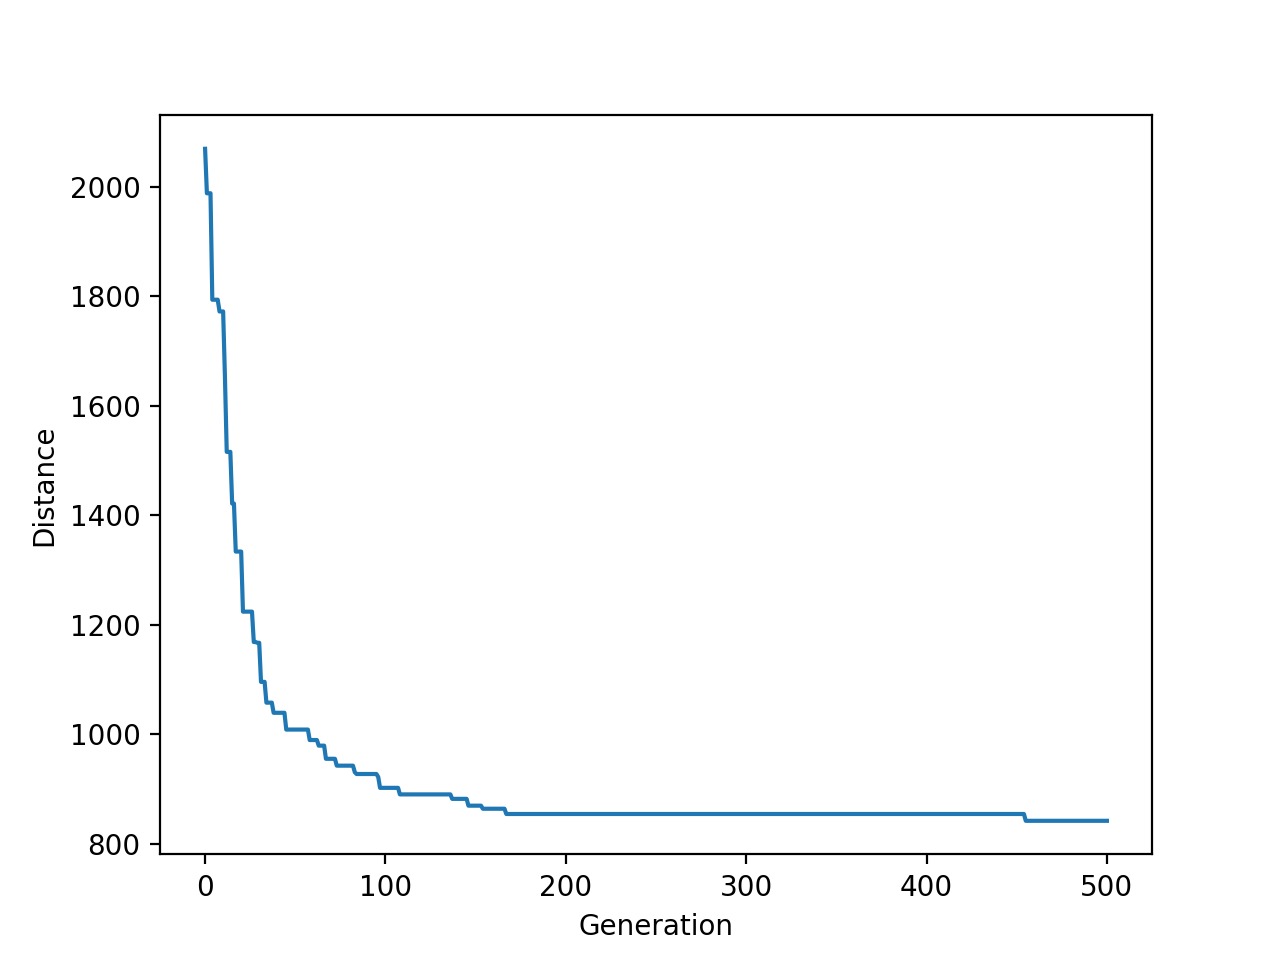

In [115]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)


In [73]:
#Keeps saying that there is no modue named "logProcess"
#from logProcess import log_progress

In [99]:
#Generate more data for the graph
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [103]:
#Smaller group for testing the adding of methods
geneticAlgorithmPlot(population=cityList[0:10], popSize=20, eliteSize=5, mutationRate=0.01, generations=20)

In [113]:
geneticAlgorithm(population=cityList[0:10], popSize=20, eliteSize=5, mutationRate=0.01, generations=20)

Initial distance: 839.8806172542154
Final distance: 601.4635019943215


[(48,60),
 (78,73),
 (97,36),
 (107,25),
 (175,5),
 (175,158),
 (65,174),
 (33,124),
 (1,131),
 (25,94)]

In [112]:
#def EX(parent1, parent2):

city1 = City(0,1)
city2 = City(1,0)
city3 = City(0,2)
city4 = City(2,0)


EX([city1, city3, city2, city4], [city3, city4, city1, city2])

[(1,0), (0,2), (0,1), (2,0)]

In [119]:
OX([city1, city3, city2, city4], [city3, city4, city1, city2])

[None, (0,2), (1,0), None]